In [1]:
from deap import base, creator, tools
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ==============================
# 问题参数
# ==============================
TMAX = 200          # 为演示缩短长度，实际可设1000
K = 10
P = 3

D_total = 1e8
Cap_rocket = 150        
Cap_lift = 179000       
L_max = 800

Cost_rocket = 500000
Cost_lift = 100000

# ==============================
# DEAP 初始化
# ==============================
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# 火箭发射次数 (整数)
toolbox.register("attr_R", lambda: random.randint(0, L_max))
# 电梯运输量 (连续)
toolbox.register("attr_E", lambda: random.uniform(0, Cap_lift))

def init_individual():
    """保证初始化总运输量大约 D_total / TMAX"""
    ind = []
    avg_rocket_per_year = D_total / TMAX / 2 / Cap_rocket / K
    avg_lift_per_year = D_total / TMAX / 2 / P

    for _ in range(K*TMAX):
        val = max(1, int(random.gauss(avg_rocket_per_year, avg_rocket_per_year*0.5)))
        ind.append(min(val, L_max))

    for _ in range(P*TMAX):
        val = random.gauss(avg_lift_per_year, avg_lift_per_year*0.5)
        val = max(0, min(val, Cap_lift))
        ind.append(val)

    return creator.Individual(ind)

toolbox.register("individual", init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# ==============================
# Fitness 分配
# ==============================
def assign_fitness(pop, w1=0.5, w2=0.5):
    ZC_list = []
    ZT_list = []

    for ind in pop:
        R = np.array(ind[:K*TMAX]).reshape(K, TMAX)
        E = np.array(ind[K*TMAX:]).reshape(P, TMAX)

        # 总成本
        ZC = Cost_rocket * np.sum(R) + Cost_lift * np.sum(E)

        # 总工期
        transported = 0
        ZT = TMAX
        for t in range(TMAX):
            R_t = np.sum(R[:, t]) * Cap_rocket
            E_t = np.sum(E[:, t])
            transported += R_t + E_t
            if transported >= D_total:
                ZT = t + 1
                break

        # 罚函数: 总运输量不足时增加 fitness
        
        penalty = max(0, (D_total - transported)/D_total) * 1e6

        ind.ZC = ZC
        ind.ZT = ZT
        ind.penalty = penalty

        ZC_list.append(ZC)
        ZT_list.append(ZT)

    # 种群内标准化
    std_C = np.std(ZC_list) + 1e-6
    std_T = np.std(ZT_list) + 1e-6

    for ind in pop:
        fitness_val = w1 * ind.ZC / std_C + w2 * ind.ZT / std_T + ind.penalty
        ind.fitness.values = (fitness_val,)

# ==============================
# 遗传算子
# ==============================
toolbox.register("mate", tools.cxTwoPoint)

def mutate_bound(ind, mu_R=0, sigma_R=100, mu_E=0, sigma_E=5e4, indpb=0.1):
    for i in range(len(ind)):
        if random.random() < indpb:
            if i < K*TMAX:
                ind[i] += int(round(random.gauss(mu_R, sigma_R)))
                ind[i] = max(0, min(L_max, ind[i]))
            else:
                ind[i] += random.gauss(mu_E, sigma_E)
                ind[i] = max(0, min(Cap_lift, ind[i]))
    return ind,

toolbox.register("mutate", mutate_bound)
toolbox.register("select", tools.selTournament, tournsize=3)


In [2]:
# ==============================
# 修改后的主程序 - 添加数据收集功能
# ==============================
def main_with_history():
    pop = toolbox.population(n=100)
    NGEN = 1000
    CXPB = 0.7
    MUTPB = 0.2
    
    # 用于存储历史数据的列表
    history = {
        'gen': [],           # 代数
        'best_fitness': [],  # 最佳适应度
        'best_ZC': [],       # 最佳成本
        'best_ZT': [],       # 最佳工期
        'avg_ZC': [],        # 平均成本
        'avg_ZT': [],        # 平均工期
        'pop_ZC': [],        # 每代所有个体的成本（用于帕累托图）
        'pop_ZT': []         # 每代所有个体的工期（用于帕累托图）
    }
    
    assign_fitness(pop)
    
    for gen in range(NGEN):
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))
        
        # 交叉
        for c1, c2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(c1, c2)
                del c1.fitness.values, c2.fitness.values
        
        # 变异
        for ind in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(ind)
                del ind.fitness.values
        
        assign_fitness(offspring)
        pop[:] = offspring
        
        best = tools.selBest(pop, 1)[0]
        total_transported = np.sum(best[:K*TMAX])*Cap_rocket + np.sum(best[K*TMAX:])
        
        # 收集当前代的数据
        ZC_list = [ind.ZC for ind in pop]
        ZT_list = [ind.ZT for ind in pop]
        
        history['gen'].append(gen)
        history['best_fitness'].append(best.fitness.values[0])
        history['best_ZC'].append(best.ZC)
        history['best_ZT'].append(best.ZT)
        history['avg_ZC'].append(np.mean(ZC_list))
        history['avg_ZT'].append(np.mean(ZT_list))
        history['pop_ZC'].append(ZC_list)  # 保存整个种群的成本
        history['pop_ZT'].append(ZT_list)  # 保存整个种群的工期
        
        print(f"Gen {gen}: Z={best.fitness.values[0]:.3e}, "
              f"ZC={best.ZC:.3e}, ZT={best.ZT}, TotalTransport={total_transported:.1e}")
    
    return tools.selBest(pop, 1)[0], history

In [3]:
# ==============================
# 运行 GA
# ==============================
best_ind, history = main_with_history()

R = np.array(best_ind[:K*TMAX]).reshape(K, TMAX)
E = np.array(best_ind[K*TMAX:]).reshape(P, TMAX)

ROCKET = pd.DataFrame(R)
ELEVATOR = pd.DataFrame(E)
ROCKET.to_excel((r"D:\USELESS\数据分析学习\数学建模学习\2026美赛\B\PROB01\ROCKET1.xlsx"))
ELEVATOR.to_excel((r"D:\USELESS\数据分析学习\数学建模学习\2026美赛\B\PROB01\ELEVATOR1.xlsx"))
print("最终总运输量 =", np.sum(R)*Cap_rocket + np.sum(E))
print('火箭运输量 = ', np.sum(R)*Cap_rocket)
print('太空电梯运输量 = ', np.sum(E))



K, TMAX = R.shape
P = E.shape[0]

# 计算每年总运输量
yearly_transport = np.array([R[:, t].sum()*Cap_rocket + E[:, t].sum() for t in range(TMAX)])

# 按年份运输量从大到小排序
sorted_idx = np.argsort(-yearly_transport)

# 初始化新的矩阵
R_new = np.zeros_like(R)
E_new = np.zeros_like(E)

transported = 0
ZT_new = 0

for t_new, t_old in enumerate(sorted_idx):
    # 尽量保持原有分配比例，但不超过上限
    R_year = np.minimum(R[:, t_old], L_max)
    E_year = np.minimum(E[:, t_old], Cap_lift)

    # 计算这一年的运输量
    transported += R_year.sum()*Cap_rocket + E_year.sum()
    
    # 如果运输量超过 D_total，则按比例缩减这一年的运输量
    if transported > D_total:
        excess = transported - D_total
        # 按比例缩减火箭和电梯
        total_year = R_year.sum()*Cap_rocket + E_year.sum()
        if total_year > 0:
            ratio = (total_year - excess) / total_year
            R_year = np.floor(R_year * ratio)  # 保留整数
            E_year = E_year * ratio
        transported = D_total
        ZT_new = t_new + 1
        R_new[:, t_new] = R_year
        E_new[:, t_new] = E_year
        break
    
    R_new[:, t_new] = R_year
    E_new[:, t_new] = E_year
    ZT_new = t_new + 1

print(f"压缩后最早完成 D_total 的年份 ZT_new = {ZT_new}")
print(f"压缩后总运输量 = {transported}")

ZC_new = (Cost_rocket * np.sum(R_new[:, :ZT_new]) + 
          Cost_lift * np.sum(E_new[:, :ZT_new]))

print(f"压缩后总成本 = {ZC_new:.3e}")
print(f"火箭总运输量 = {R_new.sum()*Cap_rocket}")
print(f"电梯总运输量 = {E_new.sum()}")


R = np.array(best_ind[:K*TMAX]).reshape(K, TMAX)
E = np.array(best_ind[K*TMAX:]).reshape(P, TMAX)

ROCKET = pd.DataFrame(R)
ELEVATOR = pd.DataFrame(E)

ROCKET.to_excel((r"D:\USELESS\数据分析学习\数学建模学习\2026美赛\B\PROB01\ROCKET_final.xlsx"))
ELEVATOR.to_excel((r"D:\USELESS\数据分析学习\数学建模学习\2026美赛\B\PROB01\_final.xlsx"))

Gen 0: Z=8.193e+01, ZC=5.154e+12, ZT=197, TotalTransport=1.0e+08
Gen 1: Z=7.226e+01, ZC=5.161e+12, ZT=197, TotalTransport=1.0e+08
Gen 2: Z=6.786e+01, ZC=5.089e+12, ZT=198, TotalTransport=1.0e+08
Gen 3: Z=6.284e+01, ZC=5.156e+12, ZT=196, TotalTransport=1.0e+08
Gen 4: Z=6.429e+01, ZC=5.188e+12, ZT=195, TotalTransport=1.0e+08
Gen 5: Z=7.106e+01, ZC=5.122e+12, ZT=196, TotalTransport=1.0e+08
Gen 6: Z=7.368e+01, ZC=5.228e+12, ZT=193, TotalTransport=1.0e+08
Gen 7: Z=6.979e+01, ZC=5.139e+12, ZT=194, TotalTransport=1.0e+08
Gen 8: Z=7.224e+01, ZC=5.086e+12, ZT=194, TotalTransport=1.0e+08
Gen 9: Z=7.806e+01, ZC=5.208e+12, ZT=191, TotalTransport=1.0e+08
Gen 10: Z=1.004e+02, ZC=5.204e+12, ZT=190, TotalTransport=1.0e+08
Gen 11: Z=1.035e+02, ZC=5.207e+12, ZT=189, TotalTransport=1.1e+08
Gen 12: Z=1.098e+02, ZC=5.207e+12, ZT=189, TotalTransport=1.1e+08
Gen 13: Z=1.082e+02, ZC=5.133e+12, ZT=190, TotalTransport=1.0e+08
Gen 14: Z=9.615e+01, ZC=5.049e+12, ZT=192, TotalTransport=1.0e+08
Gen 15: Z=1.027e+02,

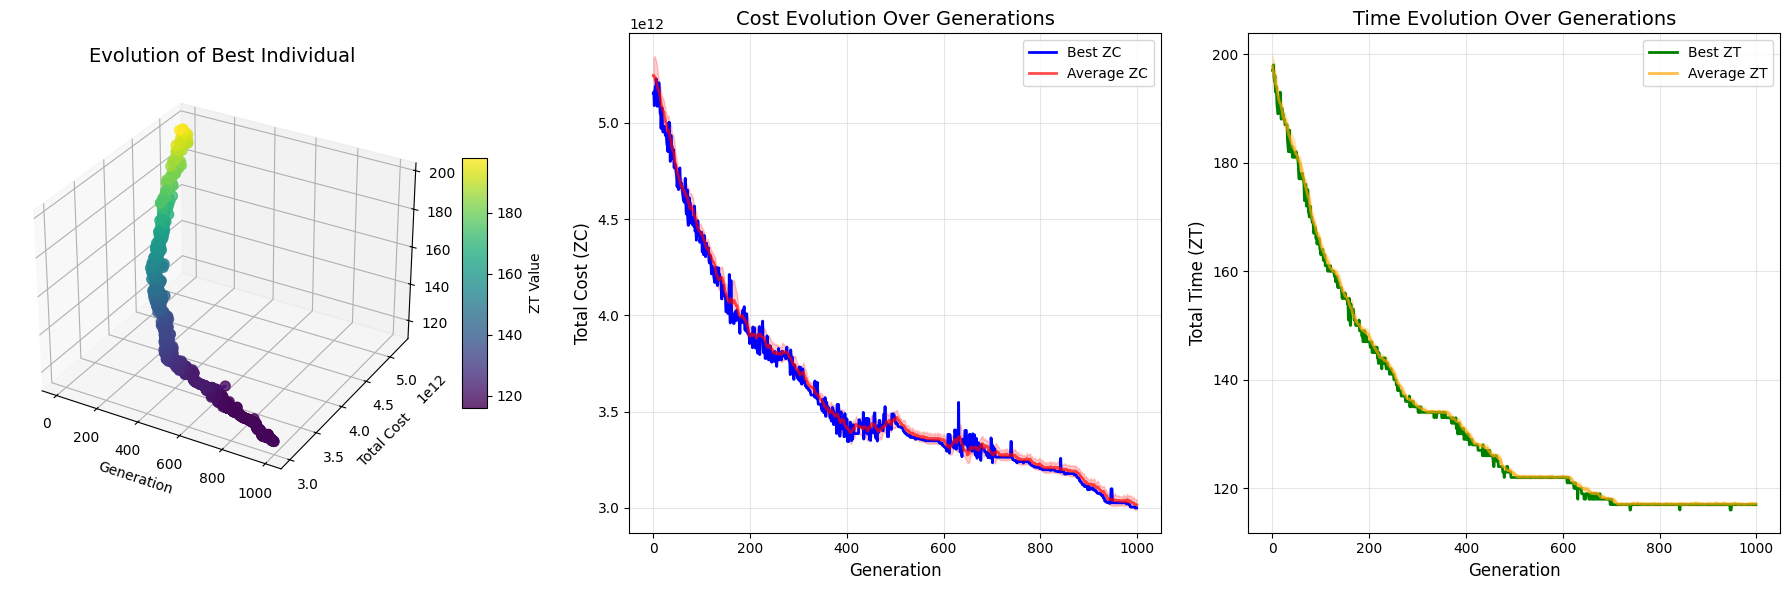

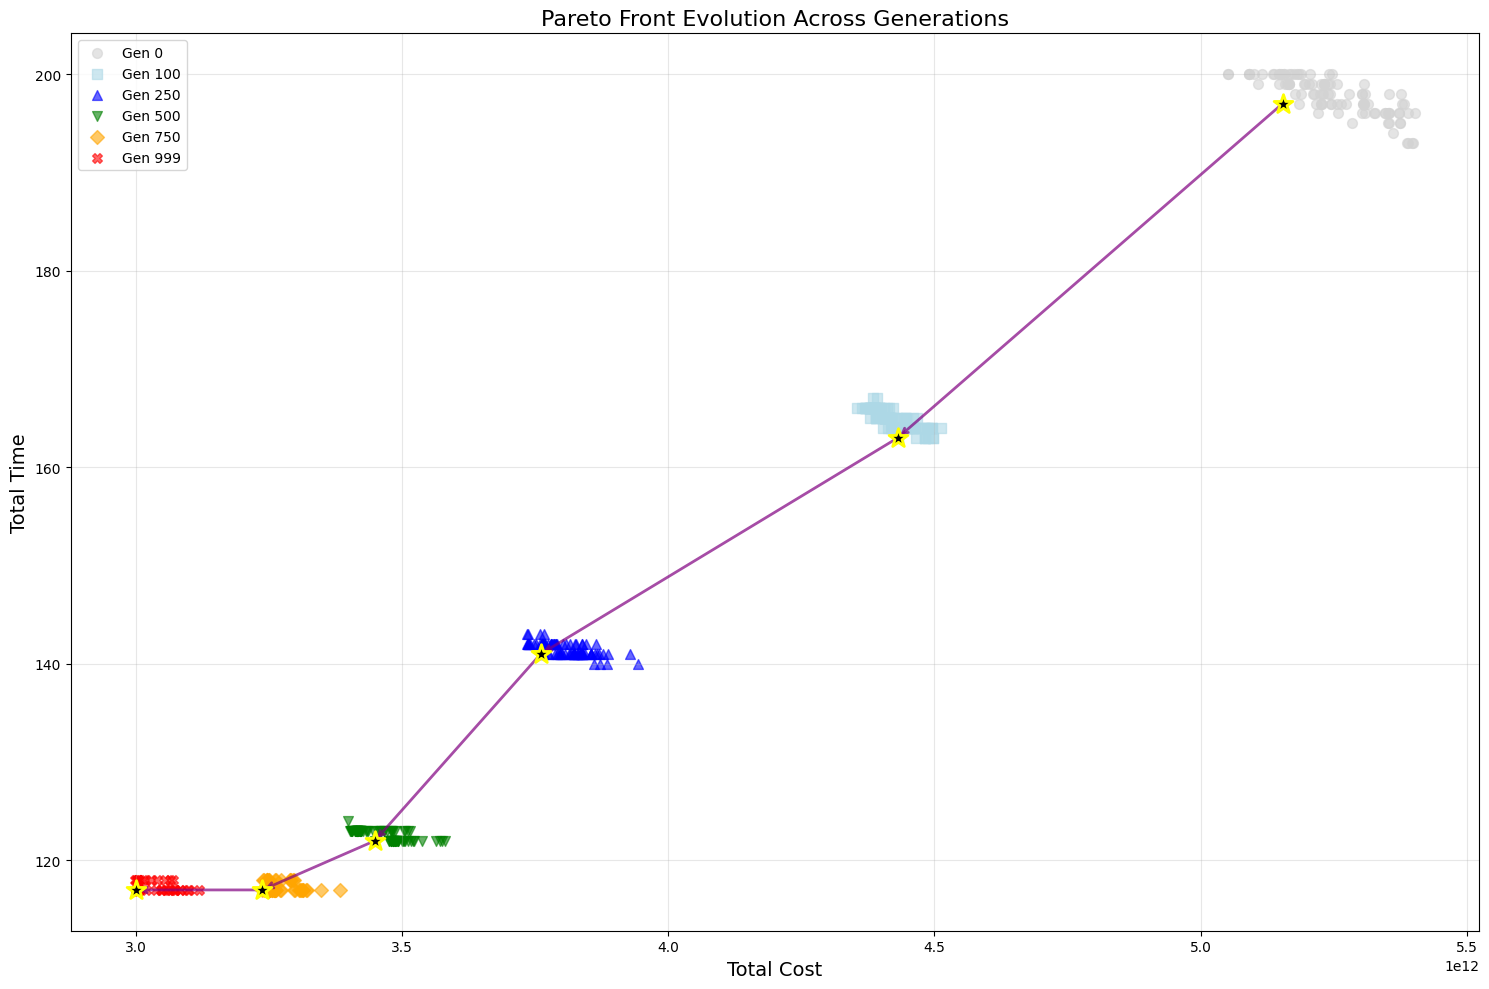

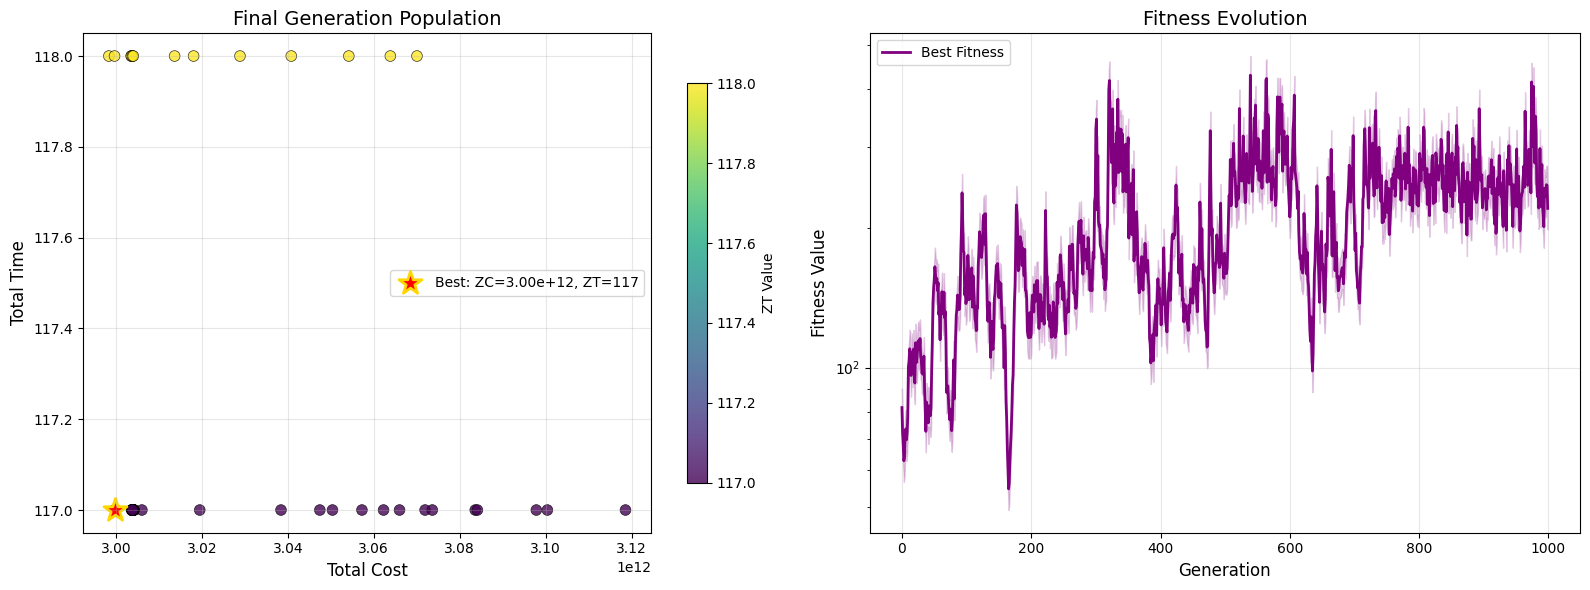

GENETIC ALGORITHM OPTIMIZATION RESULTS
Total Generations: 1000
Best Individual Found:
  - Total Cost (ZC): 3.000e+12
  - Total Time (ZT): 117 years
  - Fitness Value: 2.211e+02

Improvement Over Generations:
  - Cost Reduction: 41.79%
  - Time Reduction: 40.61%


In [15]:
# ==============================
# 可视化模块
# ==============================

# 1. 种群演化三维图（成本-工期-代数）
fig = plt.figure(figsize=(18, 6))

# 三维图 - 最佳个体演化
ax1 = fig.add_subplot(131, projection='3d')
gen_array = np.array(history['gen'])
best_ZC_array = np.array(history['best_ZC'])
best_ZT_array = np.array(history['best_ZT'])

# 将成本标准化以便更好地显示
best_ZC_norm = (best_ZC_array - np.min(best_ZC_array)) / (np.max(best_ZC_array) - np.min(best_ZC_array) + 1e-10)

# 绘制三维线图
ax1.plot(gen_array, best_ZC_array, best_ZT_array, 'b-', linewidth=2, alpha=0.7, label='Best Individual')
# 绘制三维散点图
scatter1 = ax1.scatter(gen_array, best_ZC_array, best_ZT_array, 
                      c=best_ZT_array, cmap='viridis', s=50, alpha=0.8)

ax1.set_xlabel('Generation', fontsize=10)
ax1.set_ylabel('Total Cost', fontsize=10)
ax1.set_zlabel('Total Time', fontsize=1)

ax1.set_title('Evolution of Best Individual', fontsize=14)
ax1.grid(True, alpha=0.3)
cbar1 = fig.colorbar(scatter1, ax=ax1, shrink=0.5, aspect=10)
cbar1.set_label('ZT Value', fontsize=10)

# 2. 二维演化图 - 成本
ax2 = fig.add_subplot(132)
ax2.plot(history['gen'], history['best_ZC'], 'b-', linewidth=2, label='Best ZC')
ax2.plot(history['gen'], history['avg_ZC'], 'r-', linewidth=2, alpha=0.7, label='Average ZC')
ax2.fill_between(history['gen'], 
                 np.array(history['avg_ZC']) - np.array([np.std(zc) for zc in history['pop_ZC']]),
                 np.array(history['avg_ZC']) + np.array([np.std(zc) for zc in history['pop_ZC']]),
                 alpha=0.2, color='red')
ax2.set_xlabel('Generation', fontsize=12)
ax2.set_ylabel('Total Cost (ZC)', fontsize=12)
ax2.set_title('Cost Evolution Over Generations', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. 二维演化图 - 工期
ax3 = fig.add_subplot(133)
ax3.plot(history['gen'], history['best_ZT'], 'g-', linewidth=2, label='Best ZT')
ax3.plot(history['gen'], history['avg_ZT'], 'orange', linewidth=2, alpha=0.7, label='Average ZT')
ax3.fill_between(history['gen'], 
                 np.array(history['avg_ZT']) - np.array([np.std(zt) for zt in history['pop_ZT']]),
                 np.array(history['avg_ZT']) + np.array([np.std(zt) for zt in history['pop_ZT']]),
                 alpha=0.2, color='orange')
ax3.set_xlabel('Generation', fontsize=12)
ax3.set_ylabel('Total Time (ZT)', fontsize=12)
ax3.set_title('Time Evolution Over Generations', fontsize=14)
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. 帕累托前沿图（多代对比）
fig2 = plt.figure(figsize=(15, 10))

# 选择几个关键代进行显示
key_generations = [0, 100, 250, 500, 750, 999]
colors = ['lightgray', 'lightblue', 'blue', 'green', 'orange', 'red']
markers = ['o', 's', '^', 'v', 'D', 'X']

for i, gen in enumerate(key_generations):
    if gen < len(history['gen']):
        # 获取该代的所有个体
        ZC_values = history['pop_ZC'][gen]
        ZT_values = history['pop_ZT'][gen]
        
        # 绘制散点
        plt.scatter(ZC_values, ZT_values, 
                   c=colors[i], marker=markers[i], s=50, 
                   alpha=0.6, label=f'Gen {gen}')
        
        # 标记最佳个体
        best_idx = np.argmin([history['best_fitness'][gen]])
        plt.scatter(history['best_ZC'][gen], history['best_ZT'][gen], 
                   c='black', marker='*', s=200, edgecolors='yellow', 
                   linewidth=2, zorder=5)


plt.xlabel('Total Cost', fontsize=14)
plt.ylabel('Total Time', fontsize=14)
plt.title('Pareto Front Evolution Across Generations', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)

# 添加箭头表示演化方向
if len(key_generations) > 1:
    for i in range(len(key_generations)-1):
        gen1 = key_generations[i]
        gen2 = key_generations[i+1]
        if gen1 < len(history['gen']) and gen2 < len(history['gen']):
            plt.annotate('', 
                        xy=(history['best_ZC'][gen2], history['best_ZT'][gen2]),
                        xytext=(history['best_ZC'][gen1], history['best_ZT'][gen1]),
                        arrowprops=dict(arrowstyle='->', color='purple', lw=2, alpha=0.7))

plt.tight_layout()
plt.show()

# 5. 最终代的帕累托前沿详细图
final_gen = len(history['gen']) - 1
fig3, (ax4, ax5) = plt.subplots(1, 2, figsize=(16, 6))

# 左图：最终代所有个体
final_ZC = history['pop_ZC'][final_gen]
final_ZT = history['pop_ZT'][final_gen]

scatter_final = ax4.scatter(final_ZC, final_ZT, c=final_ZT, cmap='viridis', 
                           s=60, alpha=0.8, edgecolors='k', linewidth=0.5)

# 标记最佳个体
best_final_idx = np.argmin(history['best_fitness'])
ax4.scatter(history['best_ZC'][final_gen], history['best_ZT'][final_gen], 
           c='red', marker='*', s=300, edgecolors='gold', linewidth=2, 
           label=f'Best: ZC={history["best_ZC"][final_gen]:.2e}, ZT={history["best_ZT"][final_gen]}')

ax4.set_xlabel('Total Cost', fontsize=12)
ax4.set_ylabel('Total Time', fontsize=12)
ax4.set_title(f'Final Generation Population', fontsize=14)
ax4.legend()
ax4.grid(True, alpha=0.3)
cbar_final = fig3.colorbar(scatter_final, ax=ax4, shrink=0.8)
cbar_final.set_label('ZT Value', fontsize=10)

# 右图：适应度演化
ax5.plot(history['gen'], history['best_fitness'], 'purple', linewidth=2, label='Best Fitness')
ax5.fill_between(history['gen'], 
                 np.array(history['best_fitness']) - 0.1*np.array(history['best_fitness']),
                 np.array(history['best_fitness']) + 0.1*np.array(history['best_fitness']),
                 alpha=0.2, color='purple')
ax5.set_xlabel('Generation', fontsize=12)
ax5.set_ylabel('Fitness Value', fontsize=12)
ax5.set_title('Fitness Evolution', fontsize=14)
ax5.set_yscale('log')
ax5.legend()
ax5.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 打印最终结果摘要
print("="*60)
print("GENETIC ALGORITHM OPTIMIZATION RESULTS")
print("="*60)
print(f"Total Generations: {len(history['gen'])}")
print(f"Best Individual Found:")
print(f"  - Total Cost (ZC): {history['best_ZC'][-1]:.3e}")
print(f"  - Total Time (ZT): {history['best_ZT'][-1]} years")
print(f"  - Fitness Value: {history['best_fitness'][-1]:.3e}")
print(f"\nImprovement Over Generations:")
print(f"  - Cost Reduction: {((history['best_ZC'][0] - history['best_ZC'][-1])/history['best_ZC'][0]*100):.2f}%")
print(f"  - Time Reduction: {((history['best_ZT'][0] - history['best_ZT'][-1])/history['best_ZT'][0]*100):.2f}%")
print("="*60)